In [1]:
import random
import os

os.environ["DEBUG"] = "1"

import matplotlib.pyplot as plt
import cv2
from PIL import Image

from lib.data_aug_v2 import build_data_aug
from lib.tang_syn import synthesize
from lib.tang_syn_config import load_default_config, preload_fonts, TextlineSynthesisConfig

default_config = load_default_config()
fonts = preload_fonts(default_config)

pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Fallback font cmaps loaded.
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame commu

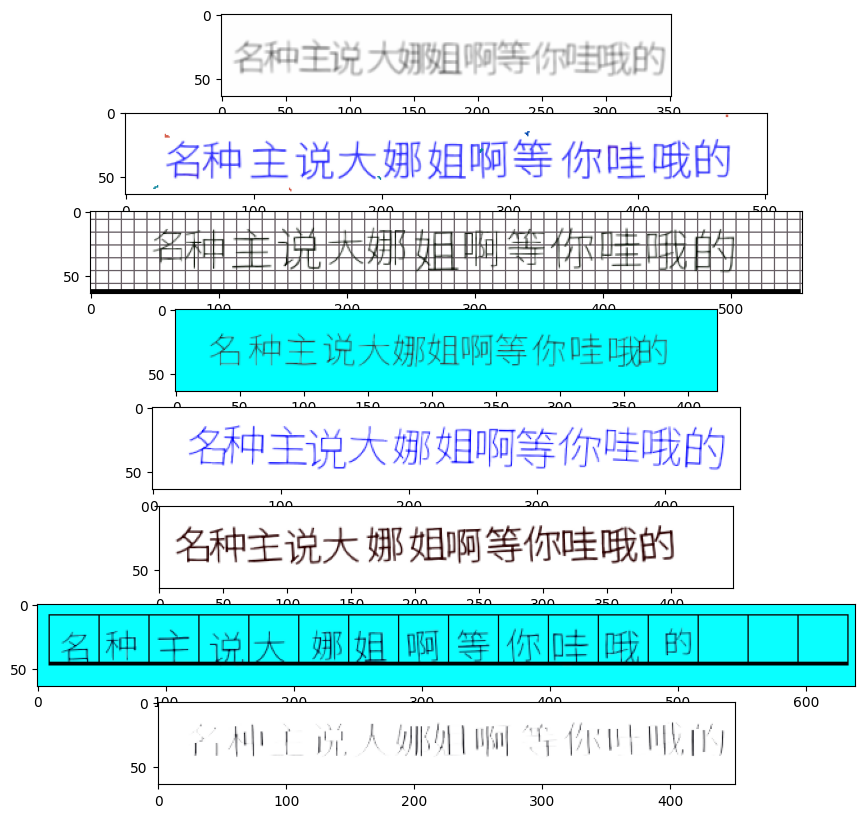

In [12]:

# message = "有人Hello Pygame你的心里没有人心心"
# message = "你好， 안녕 שָׁלוֹם 🎉🌟🙌😄！"


# transform = build_data_aug(32, "train")
# _, image = synthesize(message)
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# pillow_image = Image.fromarray(rgb_image)
# # pillow_image = transform(pillow_image)
# pillow_image.save("test.png")

transform = build_data_aug(64, "train")
fig, axs = plt.subplots(8, 1, figsize=(60, 10))

for i, ax in enumerate(axs.flatten()):
    # message = "你好，“你好：“深爱的，”带娃”Time is ripe" * random.randint(1, 2)
    message = "名种主说大娜姐啊等你哇哦的"

    default_config = load_default_config()
    
    config = TextlineSynthesisConfig.random_config(
        default_config=default_config, **fonts)

    image = synthesize(message, config)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pillow_image = Image.fromarray(rgb_image)
    pillow_image = transform(pillow_image)
    ax.imshow(pillow_image)

plt.show()

In [3]:
from fontTools.ttLib import TTFont

def can_render(ttfont, char):
    for table in ttfont['cmap'].tables:
        if table.isUnicode():
            if ord(char) in table.cmap:
                return True
    return False

ttfont = TTFont("fonts/Acy-Bold.otf")
print(can_render(ttfont, 'A'))


True


In [4]:
from datetime import datetime
import os
os.environ["DEBUG"] = "True"

from os import path
import random

import pytz
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import evaluate

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image

from transformers import VisionEncoderDecoderModel, AutoTokenizer, TrOCRProcessor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator
from transformers import get_scheduler, get_polynomial_decay_schedule_with_warmup

from data_aug_v2 import build_data_aug
from torch.utils.data import Subset
from tang_syn import synthesize

def random_slice(s, min_length=1, max_length=20):
    length = random.randint(min_length, max_length)

    if len(s) <= length:
        return s

    start = random.randint(0, len(s) - length)
    return s[start: start + length]



class OCRDataset(Dataset):

    def __init__(self,
                 dataset_dir,
                 labels_dir,
                 transform,
                 processor,
                 tokenizer,
                 mode="train",
                 max_target_length=32,
                 device=None):
        self.dataset_dir = dataset_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.device = device
        self.processor = processor
        self.mode = mode
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer
        self.df = self.build_df()
        self.df_len = len(self.df)

        if mode == "train":
            self.file_handles = self.load_texts()
            self.arbitrary_len = 12000000

    def __len__(self):
        return self.arbitrary_len

    def __getitem__(self, idx):

        # Thirty percent of the time, use existing dataset
        if idx < self.df_len:
            text = self.df['text'][idx]
            # get file name + text
            file_name = self.df["file_name"][idx]
            # prepare image (i.e. resize + normalize)
            image = Image.open(path.join(self.dataset_dir,
                                         file_name)).convert("RGB")

        else:
            text, bgr_image = self.sample_and_synthesize()
            rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(rgb_image)

        if self.transform:
            image = self.transform(image)
        
        print(text)

        return image

    def build_df(self):
        li = []
        for file in tqdm(os.listdir(self.labels_dir)):
            if not file.endswith(".tsv"):
                continue

            # print(f"Reading {file}")

            li.append(
                pd.read_table(path.join(self.labels_dir, file),
                              names=["file_name", "text"]))

        return pd.concat(li, axis=0, ignore_index=True)

    def load_texts(self):
        """Load text files"""
        index_dir = path.join("dataset-syn", "indexes")
        labels_dir = path.join("dataset-syn", "labels")

        file_handles = []

        for file in tqdm(os.listdir(index_dir)):
            if not file.endswith(".tsv"):
                continue

            # print(f"Reading {file}")

            with open(path.join(index_dir, file), "r", encoding="utf-8") as index_file:
                for line in index_file:
                    line = line.strip()
                    if line:
                        file, length = line.split("\t")
                        file_path = path.join(labels_dir, file)
                        file_handles.append((file_path, int(length)))

        return file_handles

    def sample_line_from_texts(self):
        """Sample line from file handles"""
        file_path, handle_len = random.choice(self.file_handles)
        line_index = random.randint(0, handle_len - 1)

        # print(file_path, line_index)
        line = None

        with open(file_path, "r", encoding="utf-8") as handle:
            for i, lne in enumerate(handle):
                if i != line_index:
                    continue

                line = lne.strip()

        if not (isinstance(line, str) and len(line) > 0):
            raise ValueError(f"Empty line at line {line_index} of {file_path}")

        # print(
        #     f"Empty line at line {line_index} of {file_path}, retrying.")
        return line

    def sample_and_synthesize(self):
        try:
            text = self.sample_line_from_texts()
            text = random_slice(text, max_length=self.max_target_length)
            bgr_image = synthesize(text)
            return text, bgr_image
        except ValueError as sample_err:
            print(sample_err)
            return self.sample_and_synthesize()


dataset_dir = 'dataset/data'
vision_hf_model = 'facebook/deit-base-distilled-patch16-384'
# nlp_hf_model = "hfl/chinese-macbert-base"
nlp_hf_model = "Langboat/mengzi-bert-L6-H768"

processor = TrOCRProcessor.from_pretrained(
    "microsoft/trocr-base-handwritten")

tokenizer = AutoTokenizer.from_pretrained(nlp_hf_model)
train_dataset = OCRDataset(dataset_dir=dataset_dir,
                           labels_dir="dataset/labels/train",
                           tokenizer=tokenizer,
                           processor=processor,
                           mode="train",
                           transform=build_data_aug(64, "train"),
                           max_target_length=32)

年7月1日，越北联区改组为越北自治区。北宁省划归中央政府直
子和镶嵌遗传分析等多项发明为全球广为应用并成功
Unable to generate font metrics for 严。同年10月，米尔扎因和其他领导人如阿尤布·汗意见
车站概要
共有4,
建筑曾是以色列最高的建筑物，但随着特拉维夫竣工，现在是以色列
群雄逐鹿
道不消嘱咐我这一
中除正职军官外，亦有大部分杂职及


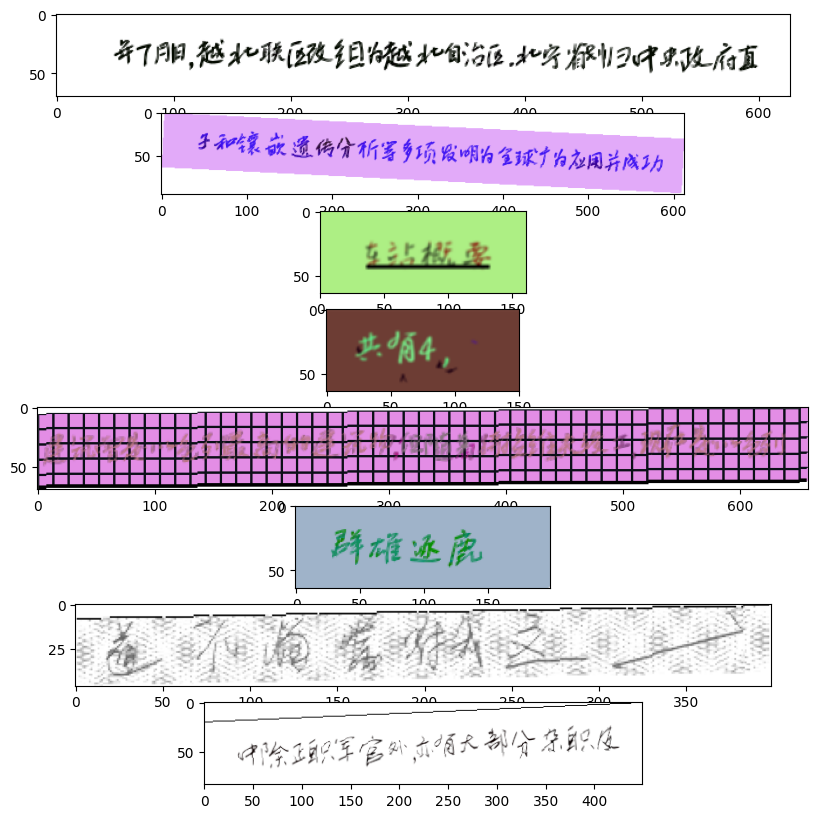

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(60, 10))

for i, ax in enumerate(axs.flatten()):
    idx = random.randint(0, len(train_dataset)-1)
    ax.imshow(train_dataset[idx])

plt.show()